# Меня ждут миллионы

Обучите простую модель предсказания цены акций. Используйте один из рассмотренных на лекции "Временные последовательности" алгоритмов предсказания рядов. Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1 лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модель на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью модели 
    
    Отобразите на графике предсказание модели и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import copy
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm
from dateutil.relativedelta import relativedelta

# Source: https://www.statsmodels.org/stable/install.html
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Source: https://scikit-learn.org/stable/install.html
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from itertools import product

import warnings

In [2]:
df = pd.read_csv('./data/raw/Amazon_Historical_StockPrice2.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,584.400024,584.750000,575.559998,579.869995,579.869995,3121500
1,2016-03-29,580.150024,595.849976,576.500000,593.859985,593.859985,4392600
2,2016-03-30,596.710022,603.239990,595.000000,598.690002,598.690002,3890500
3,2016-03-31,599.280029,600.750000,592.210022,593.640015,593.640015,2681800
4,2016-04-01,590.489990,599.030029,588.299988,598.500000,598.500000,2917400


In [3]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


,Open,High,Low,Close,Adj Close,Volume
count,1260.000000,1260.000000,1260.000000,1260.000000,1260.000000,1.260000e+03
mean,1677.254199,1694.635633,1657.249580,1676.504673,1676.504673,4.318210e+06
std,787.593224,798.250932,774.769809,786.149289,786.149289,2.089566e+06
min,580.150024,584.750000,575.559998,579.869995,579.869995,8.813000e+05
25%,967.990005,974.467499,959.544983,966.027512,966.027512,2.908675e+06
50%,1676.494995,1698.104980,1654.445007,1671.174988,1671.174988,3.716250e+06
75%,1932.977478,1951.877502,1908.004974,1928.965027,1928.965027,5.122475e+06
max,3547.000000,3552.250000,3486.689941,3531.449951,3531.449951,1.656500e+07


Далее нужно дропнуть все ненужное, то есть оставить только `High`.
Так же сделам индексирование по датам.
Перейдем к месячному интервалу и максимальному значению акции на нем.

In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')
df = df.drop(['Open', 'Low', 'Close', 'Adj Close', 'Volume'], axis=1)

In [5]:
df = df.set_index(['Date'])
ohlc_dict = {
    'High':'max',
    }
df = df.High.resample('W').agg(ohlc_dict)
df.head()

,High
Date,
2016-04-03,603.239990
2016-04-10,602.390015
2016-04-17,626.770020
2016-04-24,638.010010
2016-05-01,669.979980


In [6]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2016-04-03 to 2021-03-28
Freq: W-SUN
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   High    261 non-null    float64
dtypes: float64(1)
memory usage: 4.1 KB


,High
count,261.000000
mean,1721.992334
std,814.779297
min,602.390015
25%,991.739990
50%,1716.199951
75%,1993.020020
max,3552.250000


Как можно заметить, новый график не имеет ярких выбросов и имеет ярко выраженный тренд. Из это можно сделать вывод о том, что ряд не является стационарным.

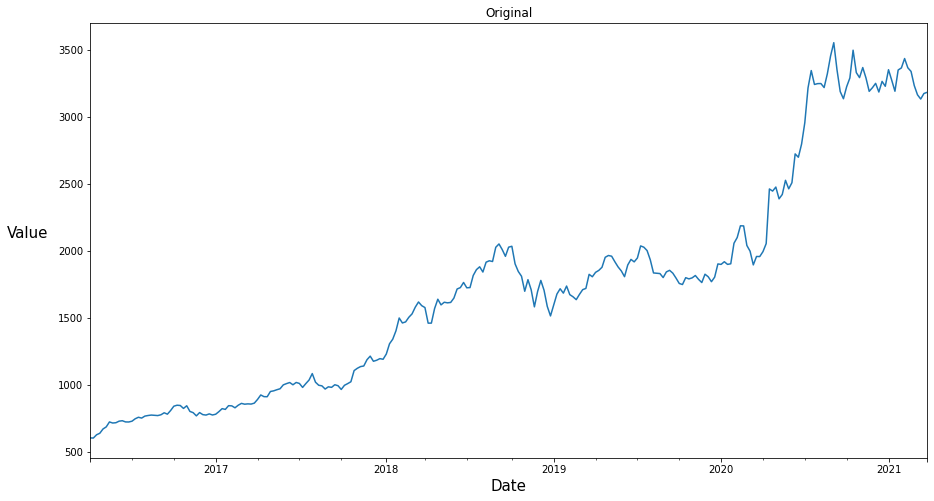

In [7]:
plt.figure(figsize=(15, 8))
plt.title('Original')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Value', rotation=0, labelpad=30, fontsize=15)
df['High'].plot();

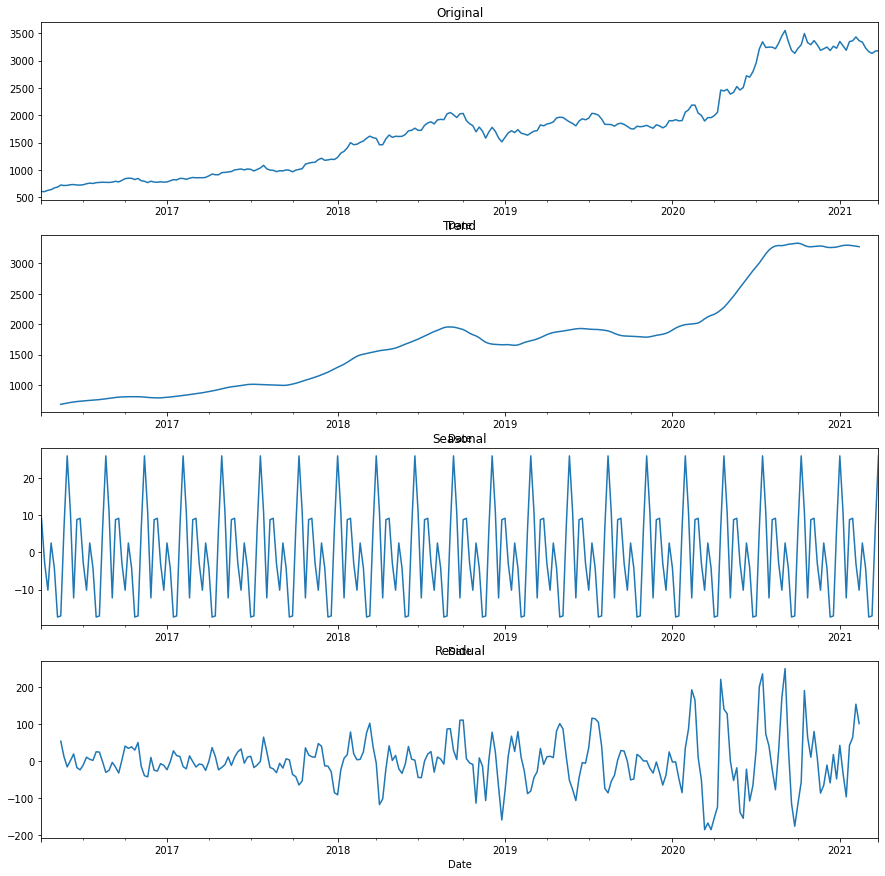

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 15))
decompose = seasonal_decompose(df[['High']], period=12)

ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')
ax[3].set_title('Residual')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

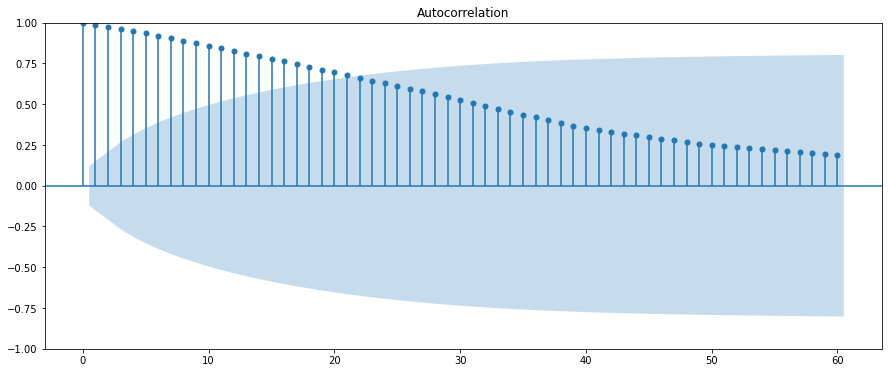

In [9]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df['High'], lags=60, ax=ax);

In [10]:
p_value = adfuller(df['High'])[1]
print(
    f' Полученный уровень значимости (p-value): {round(p_value, 4)}.\n',
    f'{round(p_value, 4)} > 0.05.\n Нулевая гипотеза не отвергнута в пользу альтернативной!'
)

 Полученный уровень значимости (p-value): 0.9424.
 0.9424 > 0.05.
 Нулевая гипотеза не отвергнута в пользу альтернативной!


In [11]:
df['HighLog'] = np.log(df['High'])
df.head()

,High,HighLog
Date,,
2016-04-03,603.239990,6.402315
2016-04-10,602.390015,6.400905
2016-04-17,626.770020,6.440580
2016-04-24,638.010010,6.458354
2016-05-01,669.979980,6.507248


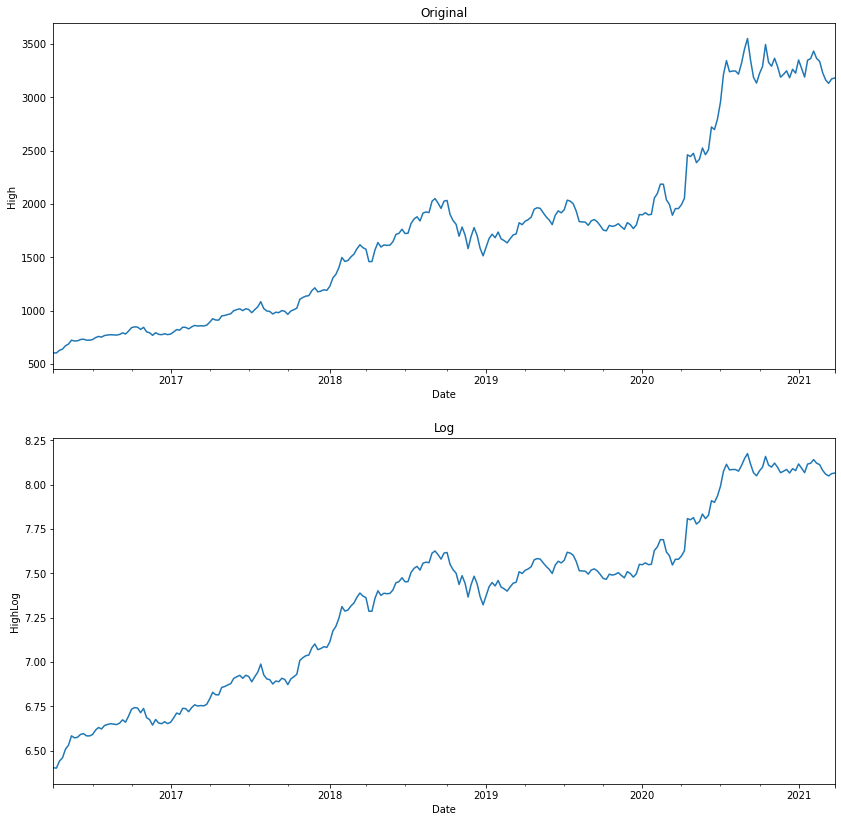

In [12]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax[0].set_title('Original')
ax[0].set_ylabel('High')
df['High'].plot(ax=ax[0])

ax[1].set_title('Log')
ax[1].set_ylabel('HighLog')
df['HighLog'].plot(ax=ax[1]);

In [13]:
p_value = adfuller(df['HighLog'][1:])[1]

print(
    f' Полученный уровень значимости (p-value): {round(p_value, 4)}.\n',
    f'{round(p_value, 4)} > 0.05.\n Нулевая гипотеза не отвергнута в пользу альтернативной!'
)

 Полученный уровень значимости (p-value): 0.7062.
 0.7062 > 0.05.
 Нулевая гипотеза не отвергнута в пользу альтернативной!


In [14]:
df['HighLogDiff'] = df['HighLog'].diff(1)
df.drop(df.head(1).index, inplace=True)
df.head()

,High,HighLog,HighLogDiff
Date,,,
2016-04-10,602.390015,6.400905,-0.001410
2016-04-17,626.770020,6.440580,0.039675
2016-04-24,638.010010,6.458354,0.017774
2016-05-01,669.979980,6.507248,0.048894
2016-05-08,685.500000,6.530148,0.022901


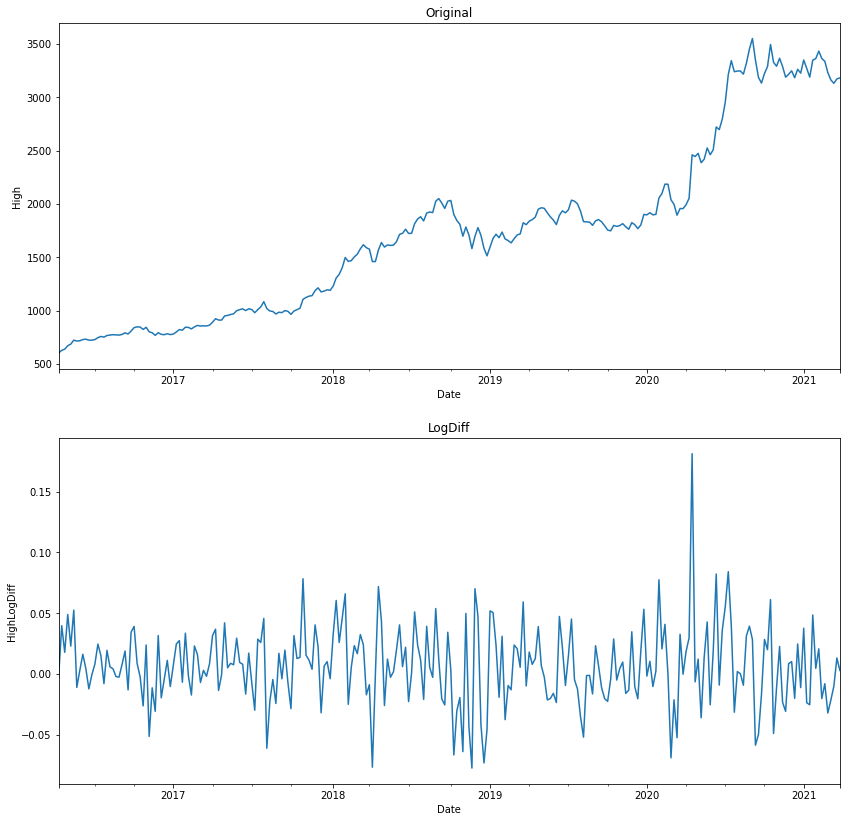

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(14, 14))

ax[0].set_title('Original')
ax[0].set_ylabel('High')
df['High'].plot(ax=ax[0])

ax[1].set_title('LogDiff')
ax[1].set_ylabel('HighLogDiff')
df['HighLogDiff'].plot(ax=ax[1]);

In [16]:
p_value = adfuller(df['HighLogDiff'][1:])[1]

print(
    f' Полученный уровень значимости (p-value): {round(p_value, 4)}.\n',
    f'{round(p_value, 4)} < 0.05.\n Нулевая гипотеза отвергается в пользу альтернативной!'
)

 Полученный уровень значимости (p-value): 0.0.
 0.0 < 0.05.
 Нулевая гипотеза отвергается в пользу альтернативной!


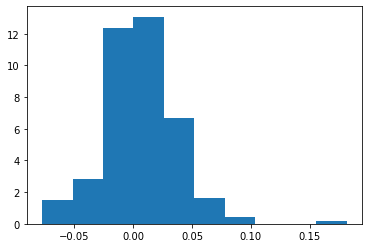

In [17]:
plt.hist(df['HighLogDiff'], density=True, bins=10);

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


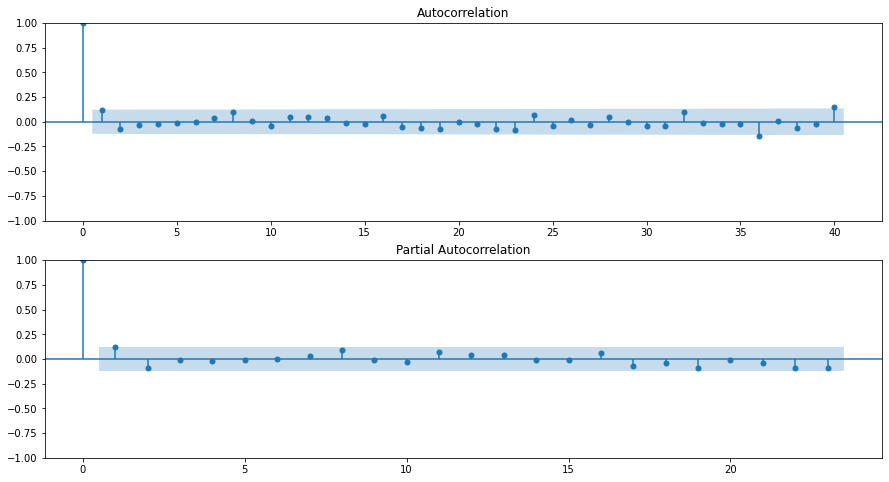

In [18]:
plt.figure(figsize=(15,8))

ax = plt.subplot(211)
statsmodels.graphics.tsaplots.plot_acf(df['HighLogDiff'], lags=40, ax=ax)

ax = plt.subplot(212)
statsmodels.graphics.tsaplots.plot_pacf(df['HighLogDiff'], lags=23, ax=ax);

In [19]:
d=1
D=1

qs = range(0, 5)
Qs = range(0, 5)

ps = range(0, 5)
Ps = range(0, 5)

size = len(df['HighLog'])
percentile = int(0.8 * size)

high_log_train = df['HighLog'][:percentile]
high_train = df['High'][:percentile]
high_test = df['High'][percentile:]

In [20]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

625

In [21]:
%%time
import statsmodels.api as sm

results = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    try:
        model = sm.tsa.statespace.SARIMAX(
            high_log_train,
            order=(param[0], d, param[1]),
            seasonal_order=(param[2], D, param[3], 8)
        ).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

  1%|▎                                          | 4/625 [00:01<03:26,  3.01it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  1%|▌                                          | 9/625 [00:04<06:12,  1.65it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
  2%|▊                                         | 13/625 [00:07<06:13,  1.64it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 11%|████▊                                     | 71/625 [01:33<18:32,  2.01s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|████▊                                     | 72/625 [01:35<18:08,  1.97s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 12%|████▉                                     | 73/625 [01:37<18:11,  1.98s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 19%|███████▊                                 | 119/625 [03:08<19:33,  2.32s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 19%|███████▉                                 | 121/625 [03:14<21:04,  2.51s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 20%|████████                                 | 122/625 [03:16<19:51,  2.37s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 27%|██████████▉                              | 166/625 [04:22<13:10,  1.72s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 27%|███████████                              | 168/625 [04:25<12:44,  1.67s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 27%|███████████                              | 169/625 [04:27<14:08,  1.86s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 31%|████████████▊                            | 196/625 [05:22<18:41,  2.61s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 32%|████████████▉                            | 197/625 [05:24<17:52,  2.51s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 32%|████████████▉                            | 198/625 [05:26<17:37,  2.48s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 36%|██████████████▊                          | 225/625 [06:32<25:54,  3.89s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 36%|██████████████▊                          | 226/625 [06:32<18:46,  2.82s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 36%|██████████████▉                          | 227/625 [06:33<14:48,  2.23s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 43%|█████████████████▌                       | 268/625 [07:59<10:16,  1.73s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 43%|█████████████████▋                       | 269/625 [08:02<11:22,  1.92s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 43%|█████████████████▊                       | 271/625 [08:07<12:40,  2.15s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 47%|███████████████████▎                     | 294/625 [08:51<12:21,  2.24s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 47%|███████████████████▍                     | 296/625 [08:57<13:46,  2.51s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 48%|███████████████████▍                     | 297/625 [09:00<13:23,  2.45s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 52%|█████████████████████▎                   | 324/625 [10:00<15:03,  3.00s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 52%|█████████████████████▎                   | 325/625 [10:05<18:25,  3.68s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Pytho

 53%|█████████████████████▉                   | 334/625 [10:21<10:54,  2.25s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 54%|█████████████████████▉                   | 335/625 [10:26<14:21,  2.97s/it]/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 55%|██████████████████████▌                  | 344/625 [10:48<13:04,  2.79s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:6

 57%|███████████████████████▌                 | 359/625 [11:35<11:59,  2.71s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 58%|███████████████████████▌                 | 360/625 [11:41<15:21,  3.48s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 58%|███████████████████████▋                 | 361/625 [11:42<12:06,  2.75s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 64%|██████████████████████████               | 398/625 [13:12<08:47,  2.32s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 64%|██████████████████████████▏              | 399/625 [13:15<09:47,  2.60s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 64%|██████████████████████████▏              | 400/625 [13:20<12:47,  3.41s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 68%|████████████████████████████             | 427/625 [14:21<06:34,  1.99s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:6

 70%|████████████████████████████▌            | 436/625 [14:38<06:09,  1.96s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 70%|████████████████████████████▋            | 437/625 [14:40<05:42,  1.82s/it]/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 71%|█████████████████████████████▎           | 446/625 [15:04<08:34,  2.87s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:6

 73%|█████████████████████████████▊           | 455/625 [15:28<08:29,  3.00s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 73%|█████████████████████████████▉           | 456/625 [15:29<06:34,  2.33s/it]/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 74%|██████████████████████████████▌          | 465/625 [15:53<08:55,  3.35s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:6

 76%|███████████████████████████████          | 474/625 [16:21<08:23,  3.33s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 76%|███████████████████████████████▏         | 475/625 [16:28<10:52,  4.35s/it]/Library/Frameworks/Pytho

 80%|████████████████████████████████▋        | 498/625 [17:37<08:07,  3.84s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 80%|████████████████████████████████▋        | 499/625 [17:42<08:36,  4.10s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 80%|████████████████████████████████▉        | 502/625 [17:50<05:53,  2.87s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 86%|███████████████████████████████████▎     | 539/625 [19:12<03:30,  2.45s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 87%|███████████████████████████████████▍     | 541/625 [19:19<03:49,  2.73s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 87%|███████████████████████████████████▌     | 542/625 [19:21<03:32,  2.56s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

 89%|████████████████████████████████████▍    | 556/625 [20:01<02:27,  2.13s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 89%|████████████████████████████████████▌    | 557/625 [20:02<02:05,  1.84s/it]/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 91%|█████████████████████████████████████▏   | 566/625 [20:27<02:55,  2.98s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:6

 92%|█████████████████████████████████████▋   | 575/625 [21:07<04:23,  5.27s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 92%|█████████████████████████████████████▊   | 576/625 [21:07<03:07,  3.83s/it]/Library/Frameworks/Pytho

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 94%|██████████████████████████████████████▍  | 585/625 [21:34<02:32,  3.80s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:6

 95%|██████████████████████████████████████▉  | 594/625 [22:04<01:55,  3.74s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 95%|███████████████████████████████████████  | 595/625 [22:10<02:18,  4.62s/it]/Library/Frameworks/Pytho

 98%|████████████████████████████████████████ | 610/625 [23:00<00:59,  3.95s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 98%|████████████████████████████████████████ | 611/625 [23:02<00:45,  3.25s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
 98%|████████████████████████████████████████▏| 612/625 [23:05<00:39,  3.02s/it]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optim

CPU times: user 2h 39min 37s, sys: 32min 31s, total: 3h 12min 9s
Wall time: 24min 5s


In [22]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters         aic
151  (1, 1, 0, 1) -820.091089
51   (0, 2, 0, 1) -818.832618
152  (1, 1, 0, 2) -818.768493
156  (1, 1, 1, 1) -818.659176
26   (0, 1, 0, 1) -818.518560


In [23]:
print(best_model.summary())

                                     SARIMAX Results                                     
Dep. Variable:                           HighLog   No. Observations:                  208
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 8)   Log Likelihood                 414.046
Date:                           Wed, 17 Nov 2021   AIC                           -820.091
Time:                                   17:09:57   BIC                           -806.918
Sample:                               04-10-2016   HQIC                          -814.760
                                    - 03-29-2020                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6444      0.200     -3.229      0.001      -1.036      -0.253
ma.L1          0.7965      0.176      4.532

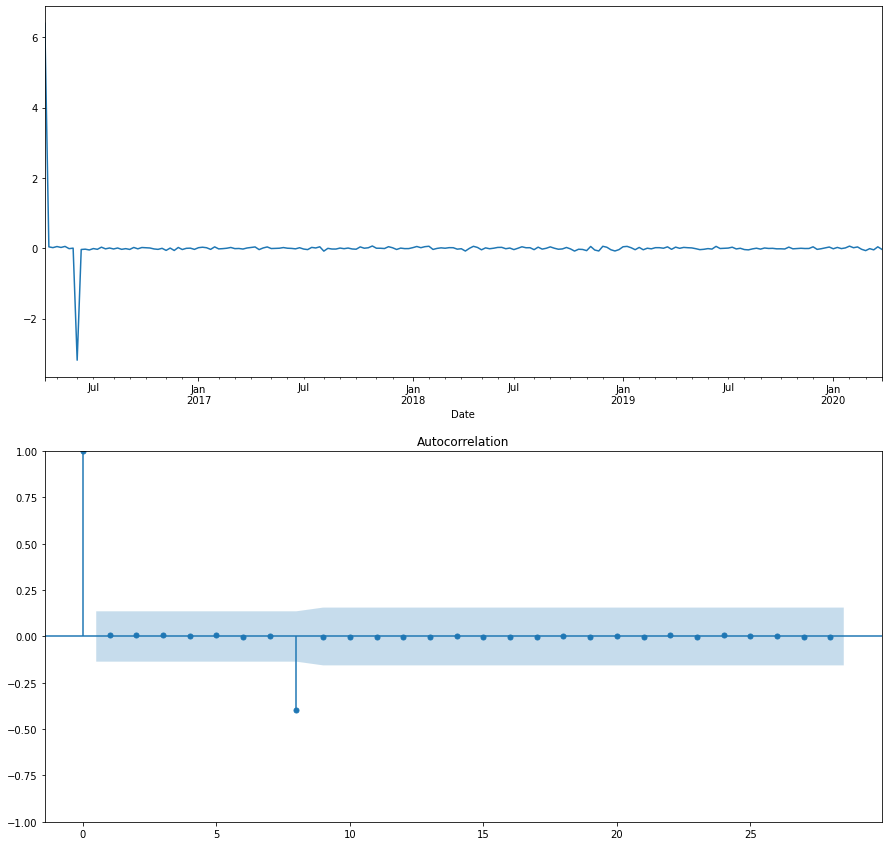

In [24]:
plt.figure(figsize=(15,15))

plt.subplot(211)
best_model.resid.plot()

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid.values.squeeze(), lags=28, ax=ax);

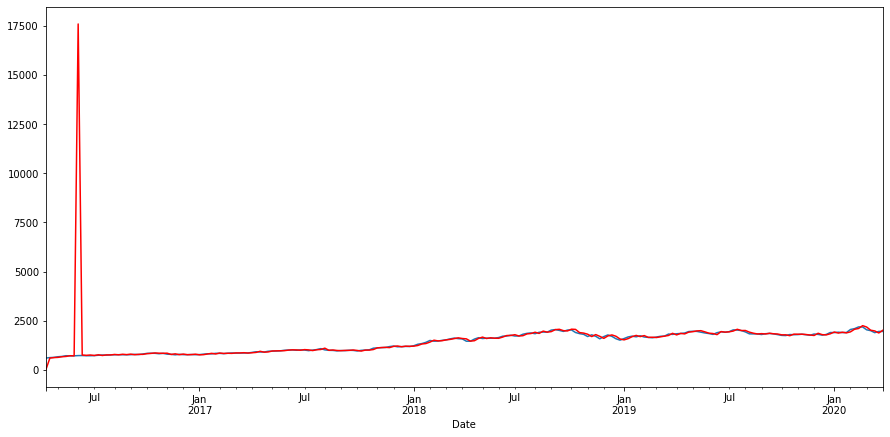

In [25]:
high_model = np.exp(best_model.fittedvalues)

plt.figure(figsize=(15,7))

high_train.plot()
high_model.plot(c='r');

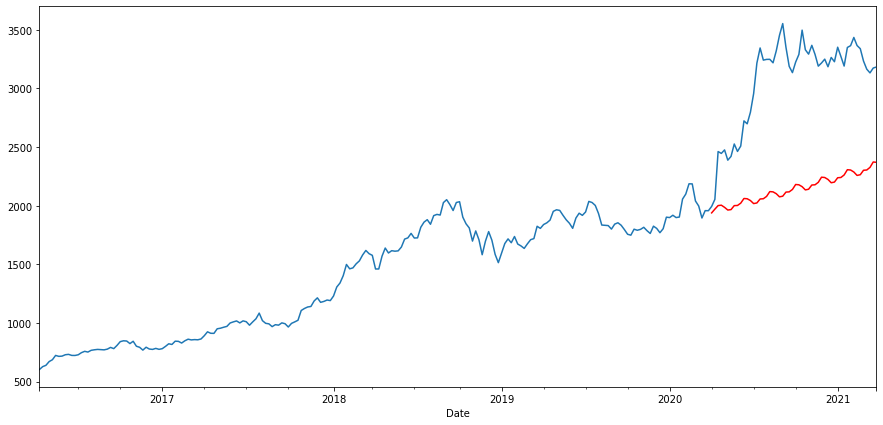

In [26]:
predict_len = size - percentile

model = np.exp(best_model.predict(start=percentile, end=percentile + predict_len - 1))

plt.figure(figsize=(15,7))
df['High'].plot()
model.plot(c='r');

In [27]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(model, high_test)


0.43007155316876317